In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
all_data = pd.read_csv('mean_data.csv')
all_data['date'] = pd.to_datetime(all_data['date'])
all_data.head()

,date,StnPres,SeaPres,Temperature,Td dew point,RH,WS,WD,WSGust,WDGust,Precp,PrecpHour,UVI,Cloud Amount
0,2016-01-01,1021.016667,1024.216667,18.712500,13.750000,73.333333,3.362500,95.000000,6.620833,100.000000,0.0,0.0,0.833333,3.257083
1,2016-01-02,1018.858333,1022.058333,19.262500,16.945833,86.666667,3.200000,47.500000,6.316667,68.333333,3.0,6.8,0.458333,9.722083
2,2016-01-03,1016.554167,1019.754167,19.225000,18.570833,96.041667,3.016667,59.583333,6.516667,89.166667,102.0,18.7,0.291667,9.576250
3,2016-01-04,1015.562500,1018.737500,21.441667,20.195833,92.833333,2.304167,79.166667,4.358333,115.000000,0.0,0.0,0.750000,7.423750
4,2016-01-05,1013.858333,1017.008333,23.041667,20.358333,85.250000,2.058333,111.666667,4.287500,157.500000,0.0,0.0,0.916667,6.722083


In [3]:
# "測站氣壓(hPa)" "StnPres"
# "海平面氣壓(hPa)" "SeaPres"
# "氣溫(℃)" "Temperature"
# "露點溫度(℃)" "Td dew point"
# "相對溼度(%)" "RH"
# "風速(m/s)" "WS"
# "風向(360degree)" "WD"
# "最大陣風(m/s)" "WSGust"
# "最大陣風風向(360degree)" "WDGust"
# "降水量(mm)" "Precp"
# "降水時數(h)" "PrecpHour"
# "日照時數(h)" "SunShine"
# "全天空日射量(MJ/㎡)" "GloblRad"
# "能見度(km)" "Visb"
# "紫外線指數" "UVI"
# "總雲量(0~10)" "Cloud Amount"

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from _utils import plot_time_series

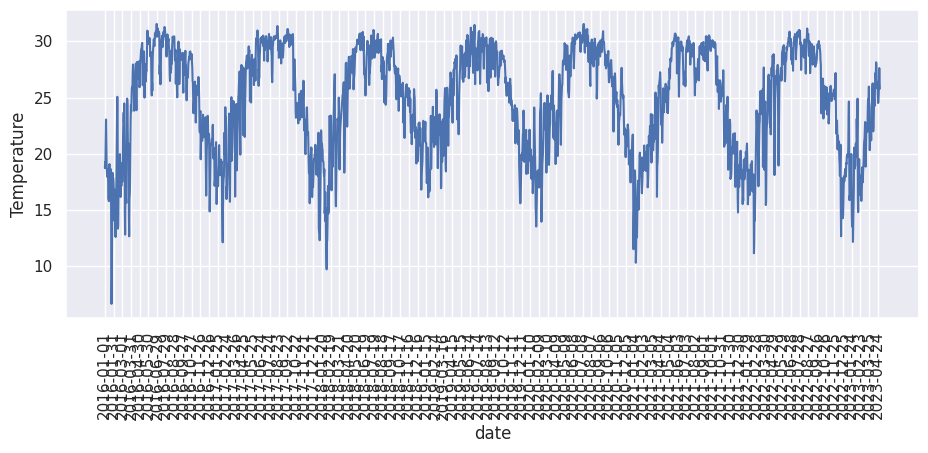

In [5]:
plot_time_series(all_data, ['Temperature'], ticks = 30)

In [6]:

train_df_raw = all_data[all_data['date'] < '2019-01-01']
test_df_raw = all_data[all_data['date'] >= '2019-01-01']

# len of train_df + test_df and len of all_data should be the same 
print("all_data length: ", len(all_data))
print("train_df length: ", len(train_df_raw))
print("test_df length: ", len(test_df_raw))

if len(all_data) == len(train_df_raw) + len(test_df_raw):
    print("num of data is matched!")
else:
    print("num of data is unmatched.")

all_data length:  2678
train_df length:  1096
test_df length:  1582
num of data is matched!


In [7]:
train_df_raw.info()
test_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1096 entries, 0 to 1095
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1096 non-null   datetime64[ns]
 1   StnPres       1096 non-null   float64       
 2   SeaPres       1096 non-null   float64       
 3   Temperature   1096 non-null   float64       
 4   Td dew point  1096 non-null   float64       
 5   RH            1096 non-null   float64       
 6   WS            1096 non-null   float64       
 7   WD            1096 non-null   float64       
 8   WSGust        1096 non-null   float64       
 9   WDGust        1096 non-null   float64       
 10  Precp         1096 non-null   float64       
 11  PrecpHour     1096 non-null   float64       
 12  UVI           1096 non-null   float64       
 13  Cloud Amount  1096 non-null   float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 128.4 KB
<class 'pandas.core.frame.DataF

# Simple Time Sequential Analysis using RNN

In [8]:
from _utils import step_window

STEP = 7
valid_split = 0.2

used_col = ["Temperature"]
train_df_used = train_df_raw[used_col]

split_point = int(len(train_df_used)*(1-valid_split))
train_df = train_df_used[:split_point]
val_df = train_df_used[split_point:]


X_train, Y_train = step_window(train_df, step=STEP)
X_val, Y_val = step_window(val_df, step=STEP)

In [9]:
# Build Model
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense, Flatten

def lstm_forecast_model(input_dim, output_dim, optimizer):
    model = Sequential()
    model.add(LSTM(256, input_shape=(input_dim[1], input_dim[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5, activation='linear'))
    model.add(Dense(output_dim))
    model.compile(loss="mean_absolute_error", optimizer=optimizer, metrics=['mean_absolute_error'])
    model.summary()
    return model

2023-05-17 01:38:29.729693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
model = lstm_forecast_model(X_train.shape, Y_train.shape[2], optimizer)
history = model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_val, Y_val), verbose=1)

2023-05-17 01:38:31.233976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 256)            264192    
                                                                 
 lstm_1 (LSTM)               (None, 7, 256)            525312    
                                                                 
 time_distributed (TimeDistr  (None, 7, 1)             257       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 7)                 0         
                                                                 
 dense_1 (Dense)             (None, 5)                 40        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                        

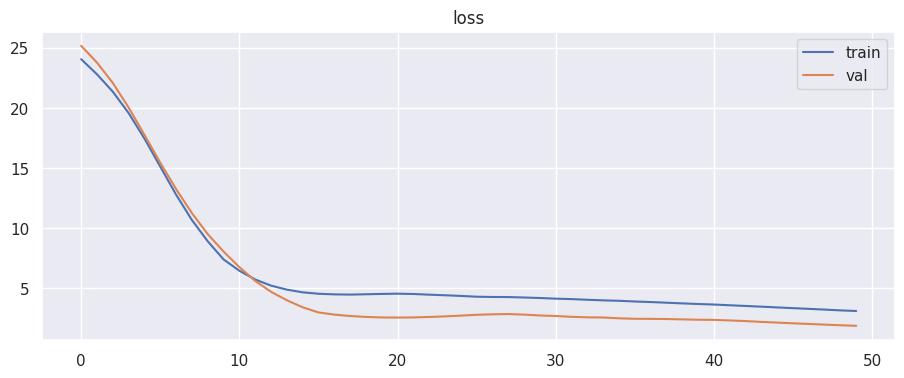

In [11]:
# plot
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('loss')
plt.legend()
plt.show()

8/8 [==============================] - 1s 12ms/step


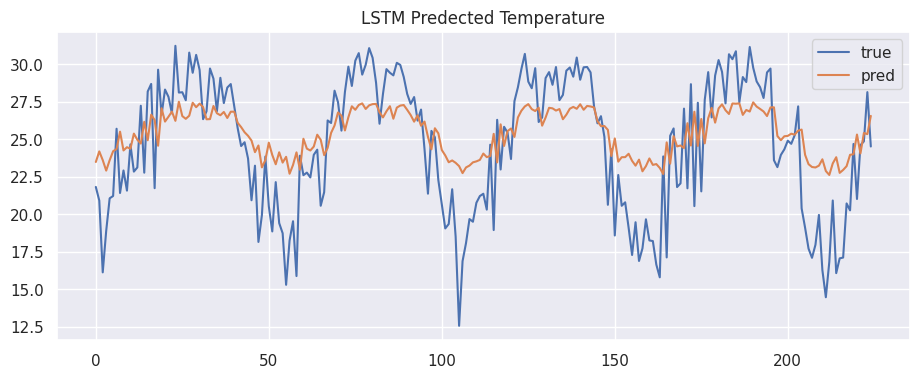

In [12]:
# predict
test_df_used = test_df_raw[used_col]
X_test, Y_test = step_window(test_df_used, step=STEP)
Y_pred = model.predict(X_test)

# plot
plt.plot(Y_test[:,0,0], label='true')
plt.plot(Y_pred[:,0], label='pred')
plt.title('LSTM Predected Temperature')
plt.legend()
plt.show()


Epoch 1/50
2/2 [==============================] - 0s 129ms/step - loss: 22.4316 - mean_absolute_error: 22.4316 - val_loss: 19.9643 - val_mean_absolute_error: 19.9643
Epoch 2/50
2/2 [==============================] - 0s 97ms/step - loss: 21.2462 - mean_absolute_error: 21.2462 - val_loss: 17.9783 - val_mean_absolute_error: 17.9783
Epoch 3/50
2/2 [==============================] - 0s 96ms/step - loss: 18.8896 - mean_absolute_error: 18.8896 - val_loss: 14.6877 - val_mean_absolute_error: 14.6877
Epoch 4/50
2/2 [==============================] - 0s 97ms/step - loss: 15.2234 - mean_absolute_error: 15.2234 - val_loss: 10.3794 - val_mean_absolute_error: 10.3794
Epoch 5/50
2/2 [==============================] - 0s 131ms/step - loss: 11.3674 - mean_absolute_error: 11.3674 - val_loss: 7.5531 - val_mean_absolute_error: 7.5531
Epoch 6/50
2/2 [==============================] - 0s 120ms/step - loss: 9.4097 - mean_absolute_error: 9.4097 - val_loss: 5.3828 - val_mean_absolute_error: 5.3828
Epoch 7/50
2/

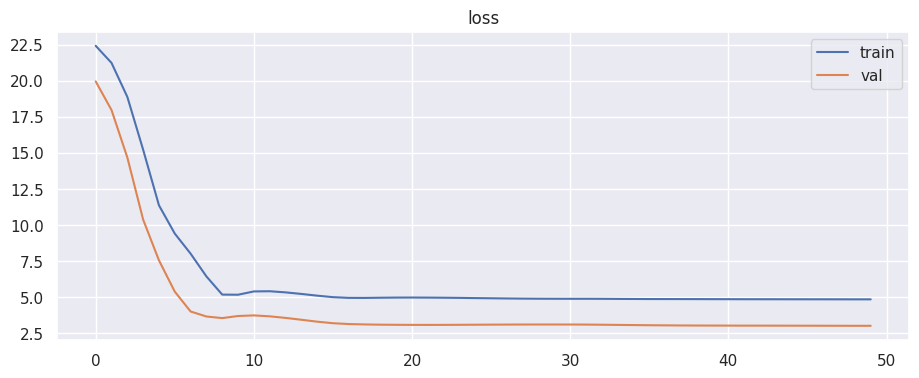

8/8 [==============================] - 0s 14ms/step


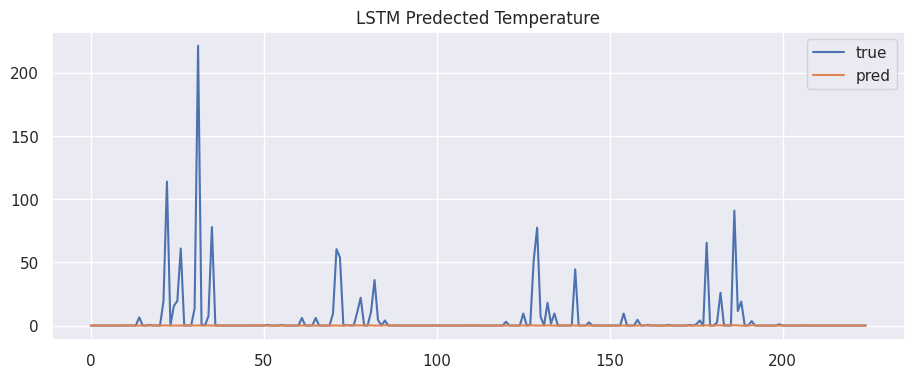

In [13]:
# 用剛剛的模型預測雨量，會發現效果不好

valid_split = 0.2

used_col = ["Precp"]    # 降水量(mm)
train_df_used = train_df_raw[used_col]

split_point = int(len(train_df_used)*(1-valid_split))
train_df = train_df_used[:split_point]
val_df = train_df_used[split_point:]


X_train, Y_train = step_window(train_df, step=STEP)
X_val, Y_val = step_window(val_df, step=STEP)
history = model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_val, Y_val), verbose=1)

# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('loss')
plt.legend()
plt.show()

# predict
test_df_used = test_df_raw[used_col]
X_test, Y_test = step_window(test_df_used, step=STEP)
Y_pred = model.predict(X_test)

# plot result
plt.plot(Y_test[:,0,0], label='true')
plt.plot(Y_pred[:,0], label='pred')
plt.title('LSTM Predected Temperature')
plt.legend()
plt.show()


# MLP+RNN
沒有依據的瞎猜，就只是個賭徒而已。

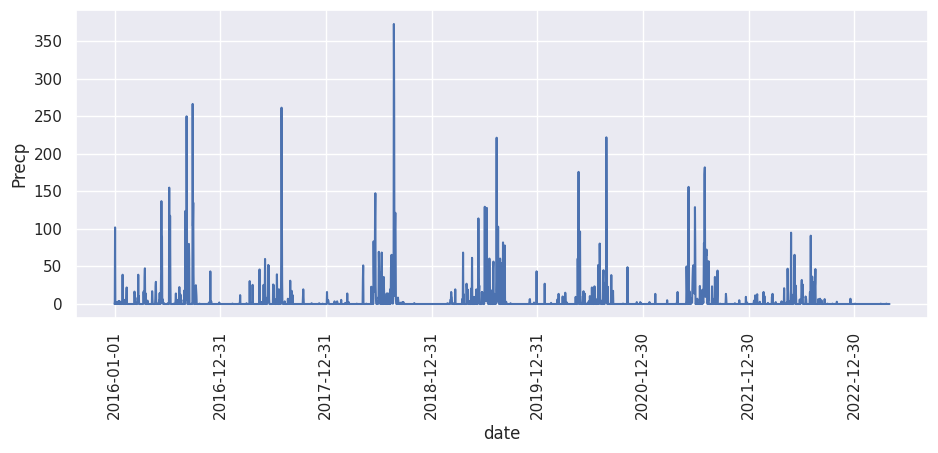

In [14]:
# 雨量資料的分布很不均衡

plot_time_series(all_data, ['Precp'], ticks = 365)

In [15]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, TimeDistributed, Dense, Flatten
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

MODEL_PATH = './best_model.pt'

In [16]:
STEP = 1
BATCH_SIZE = 16

In [17]:
# device check
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# pytorch dataset api
class dataset(Dataset):
  def __init__(self, df, step = STEP, dest_col = None):
    self.df = df
    self.dest_col = dest_col
    self.X, self.Y = step_window(train_df, step=STEP, dest_col = self.dest_col)
    self.X = torch.Tensor(np.array(self.X), device=DEVICE)
    self.Y = torch.Tensor(np.array(self.Y), device=DEVICE)
  def __len__(self):
    return self.X.shape[0]
  def __getitem__(self, idx):
    return self.X[idx], self.Y[idx]

In [19]:
# split validation dataset
valid_split = 0.2

unused_col = []
used_col = []

used_col = ["Cloud Amount", "RH", "Td dew point", "PrecpHour", "Precp", "Temperature"]
dest_col = ["Precp"]

train_df_used = train_df_raw[used_col]
split_point = int(len(train_df_used)*(1-valid_split))
train_df = train_df_used[:split_point]
val_df = train_df_used[split_point:]

In [20]:
trainset = dataset(train_df, step=STEP, dest_col = dest_col)
validset = dataset(val_df, step=STEP, dest_col = dest_col)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [21]:
# Modeling

class LSTMForecastModel(nn.Module):
    def __init__(self, input_dim, output_dim, step = STEP):
        super(LSTMForecastModel, self).__init__()

        # [n, T, params]
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.step = step
        self.lstm1 = nn.LSTM(self.input_dim, 256, batch_first=True)
        self.tanh = nn.Tanh()
        self.lstm2 = nn.LSTM(256, 256, batch_first=True)
        self.flat = nn.Flatten()
        self.fc2 = nn.Sequential(
            # input dim = output dim of lstm2 * step
            nn.Linear(256*self.step, 4000),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(4000, 512),
            nn.ReLU(),
            nn.Linear(512, self.output_dim)
        )
    
    def forward(self, x):
        x = F.normalize(x, p=1, dim=2)
        x, _ = self.lstm1(x)
        # x = self.tanh(x)
        x, _ = self.lstm2(x)
        x = self.flat(x)
        x = self.fc2(x)
        return x

In [22]:
print(X_train.shape)
print(Y_train.shape)
print(Y_val.shape)
print(f"Number of batches in trainloader : {len(trainloader)}")
print(f"Number of batches in validloader : {len(validloader)}")

for x, y in trainloader:
    print(f"batch shape x : {x.shape}")
    input_dim = x.shape[2]
    print(f"batch shape y : {y.shape}")
    output_dim = y.shape[2]
    break



(125, 7, 1)
(125, 1, 1)
(31, 1, 1)
Number of batches in trainloader : 55
Number of batches in validloader : 55
batch shape x : torch.Size([16, 1, 6])
batch shape y : torch.Size([16, 1, 1])


In [23]:
model = LSTMForecastModel(input_dim, output_dim)
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

In [24]:
def train(model, loader, criterion, optimizer):
    total_loss = 0.0
    model.train()
    for X_train, Y_train in loader:
        out = model(X_train)
        loss = criterion(out.squeeze(), Y_train.squeeze())
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return total_loss / len(loader)

def eval(model, loader, criterion):
    total_loss = 0.0
    model.eval()
    for X_val, Y_val in loader:
        with torch.no_grad():
            out = model(X_val)
            loss = criterion(out.squeeze(), Y_val.squeeze())
            total_loss += loss.item()
    return total_loss / len(loader)

In [25]:
# train
EPOCHS = 50
train_loss = []
valid_loss = []
min_loss = 1e05

for epoch in range(EPOCHS):
    loss = train(model, trainloader, criterion, optimizer)
    val_loss = eval(model, validloader, criterion)
    train_loss.append(loss)
    valid_loss.append(val_loss)

    if valid_loss[-1] < min_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        min_loss = valid_loss[-1]
        print('[WEIGHTS SAVED]')
    print(f"Epoch {epoch+1} | Loss: {loss:.5f} | Val Loss: {val_loss:.5f}")

[WEIGHTS SAVED]
Epoch 1 | Loss: 461.32564 | Val Loss: 462.26099
[WEIGHTS SAVED]
Epoch 2 | Loss: 479.89892 | Val Loss: 455.32775
Epoch 3 | Loss: 456.46311 | Val Loss: 458.32580
[WEIGHTS SAVED]
Epoch 4 | Loss: 441.88227 | Val Loss: 398.89433
Epoch 5 | Loss: 425.88987 | Val Loss: 413.58118
Epoch 6 | Loss: 414.06344 | Val Loss: 404.08852
Epoch 7 | Loss: 453.92915 | Val Loss: 461.88408
Epoch 8 | Loss: 455.70306 | Val Loss: 460.36993
Epoch 9 | Loss: 457.71860 | Val Loss: 454.17737
Epoch 10 | Loss: 456.30983 | Val Loss: 453.14526
Epoch 11 | Loss: 453.73537 | Val Loss: 452.32133
Epoch 12 | Loss: 456.72392 | Val Loss: 447.13769
Epoch 13 | Loss: 457.67304 | Val Loss: 452.00891
Epoch 14 | Loss: 453.90509 | Val Loss: 448.89457
Epoch 15 | Loss: 450.48836 | Val Loss: 426.46033
Epoch 16 | Loss: 453.29016 | Val Loss: 454.70450
Epoch 17 | Loss: 457.39785 | Val Loss: 454.20110
Epoch 18 | Loss: 489.95568 | Val Loss: 453.13618
Epoch 19 | Loss: 453.17520 | Val Loss: 448.83551
Epoch 20 | Loss: 437.11210 | V

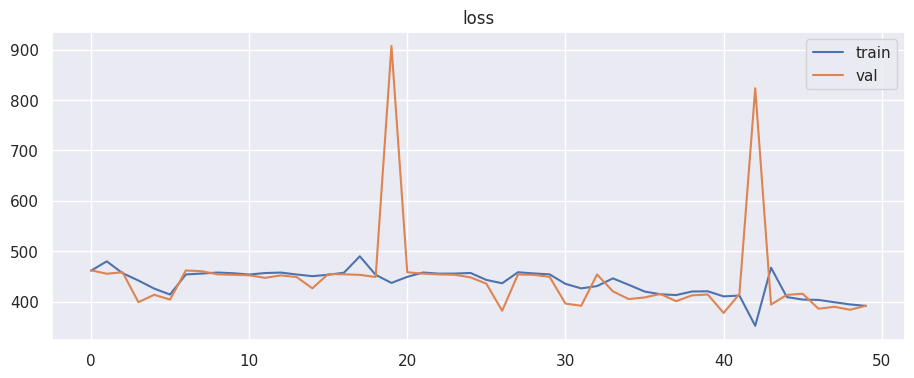

In [26]:
# plot
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='val')
plt.title('loss')
plt.legend()
plt.show()

In [27]:
torch.save(model.state_dict(), MODEL_PATH)

# Predict Section

In [9]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from _utils import step_window

MODEL_PATH = './best_model.pt'
all_data = pd.read_csv('mean_data.csv')
all_data['date'] = pd.to_datetime(all_data['date'])
used_col = ["Cloud Amount", "RH", "Td dew point", "PrecpHour", "Precp", "Temperature"]
input_dim = len(used_col)
output_dim = 1
STEP = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
col_index = {
    "Cloud Amount": 0,
    "RH": 1,
    "Td dew point": 2,
    "PrecpHour": 3,
    "Precp": 4,
    "Temperature": 5
}

In [11]:
# You can just copy the model above

class LSTMForecastModel(nn.Module):
    def __init__(self, input_dim, output_dim, step = STEP):
        super(LSTMForecastModel, self).__init__()

        # [n, T, params]
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.step = step
        self.lstm1 = nn.LSTM(self.input_dim, 256, batch_first=True)
        self.tanh = nn.Tanh()
        self.lstm2 = nn.LSTM(256, 256, batch_first=True)
        self.flat = nn.Flatten()
        self.fc2 = nn.Sequential(
            # input dim = output dim of lstm2 * step
            nn.Linear(256*self.step, 4000),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(4000, 512),
            nn.ReLU(),
            nn.Linear(512, self.output_dim)
        )
    
    def forward(self, x):
        x = F.normalize(x, p=1, dim=2)
        x, _ = self.lstm1(x)
        # x = self.tanh(x)
        x, _ = self.lstm2(x)
        x = self.flat(x)
        x = self.fc2(x)
        return x

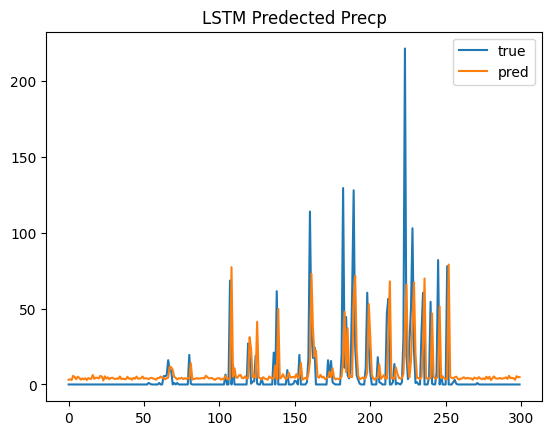

In [12]:
# predict

model = LSTMForecastModel(input_dim, output_dim)
model.load_state_dict(torch.load(MODEL_PATH))


test_df_raw = all_data[all_data['date'] >= '2019-01-01']
test_df_used = test_df_raw[used_col]
X_test, Y_test = step_window(test_df_used, step=STEP)
X_test = torch.Tensor(X_test, device=DEVICE)
Y_test = torch.Tensor(Y_test, device=DEVICE)

Y_pred = model.forward(X_test)
Y_pred = Y_pred.cpu().detach().numpy()

# plot 只印前面300筆
plt.plot(Y_test[0:300,0,col_index["Precp"]], label='true')
plt.plot(Y_pred[0:300], label='pred')
plt.title('LSTM Predected Precp')
plt.legend()
plt.show()